In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List, Tuple

# ---------------------------
# 1. Define the turbine power curve model
# ---------------------------
def turbine_power_curve(v: np.ndarray, P_rated: float, v_ci: float, v_r: float, v_co: float, p: float) -> np.ndarray:
    """
    Compute the power output for a wind turbine at wind speed v based on a piecewise model.

    Parameters:
        v (np.ndarray): Wind speed array (m/s)
        P_rated (float): Rated power output (kW)
        v_ci (float): Cut-in wind speed (m/s)
        v_r (float): Wind speed at which rated power is reached (m/s)
        v_co (float): Cut-out wind speed (m/s)
        p (float): Exponent for the ramp-up region

    Returns:
        np.ndarray: Power output (kW) for the given wind speeds.
    """
    P = np.zeros_like(v)  # Initialize power output as zero

    # Region 2: Between cut-in and rated speed - ramp-up phase
    mask_ramp = (v >= v_ci) & (v < v_r)
    P[mask_ramp] = P_rated * ((v[mask_ramp] - v_ci) / (v_r - v_ci)) ** p

    # Region 3: Between rated speed and cut-out - constant power output
    mask_flat = (v >= v_r) & (v <= v_co)
    P[mask_flat] = P_rated

    return P


In [2]:

# ---------------------------
# 2. Define the error function for parameter optimization
# ---------------------------
def error_function(params: Tuple[float, float, float, float], wind_speeds: np.ndarray, measured_power: np.ndarray, P_rated: float) -> float:
    """
    Compute the absolute error between the modeled power curve and the actual data.

    Parameters:
        params (Tuple[float, float, float, float]): Model parameters (v_ci, v_r, v_co, p)
        wind_speeds (np.ndarray): Measured wind speeds
        measured_power (np.ndarray): Measured power outputs
        P_rated (float): Rated power output (kW)

    Returns:
        float: Mean absolute error between the predicted and measured power.
    """
    v_ci, v_r, v_co, p = params
    predicted_power = turbine_power_curve(wind_speeds, P_rated, v_ci, v_r, v_co, p)
    return np.mean(np.abs(predicted_power - measured_power))


In [3]:

# ---------------------------
# 3. Function to optimize parameters using intervals
# ---------------------------
def optimize_parameters_with_intervals(data: pd.DataFrame, rated_power_values: List[float], interval: float = 0.15) -> Dict[float, Tuple[float, float, float, float]]:
    """
    Optimize the wind turbine power curve parameters using a ±interval around each rated power value.

    Parameters:
        data (pd.DataFrame): Dataset containing wind speed and power output data.
        rated_power_values (List[float]): List of rated power values to optimize for.
        interval (float): Percentage interval (default: 0.15 for ±15%)

    Returns:
        Dict[float, Tuple[float, float, float, float]]: Optimized parameters for each rated power.
    """
    optimized_params = {}

    for P_rated in rated_power_values:
        # Select data within ±interval of the rated power output
        lower_bound = P_rated * (1 - interval)
        upper_bound = P_rated * (1 + interval)
        subset = data[(data["Rated Power Output"] >= lower_bound) & (data["Rated Power Output"] <= upper_bound)]

        wind_speeds = subset["Wind Speed"].values
        measured_power = subset["Power Output"].values

        if len(wind_speeds) == 0 or len(measured_power) == 0:
            continue

        # Initial guesses for parameters
        initial_guess = [3.0, 12.0, 25.0, 3.0]
        bounds = [(2, 5), (8, 15), (20, 30), (1, 4)]

        # Optimize parameters
        result = minimize(error_function, initial_guess, args=(wind_speeds, measured_power, P_rated), bounds=bounds, method="L-BFGS-B")
        optimized_params[P_rated] = result.x

    return optimized_params


In [14]:

# ---------------------------
# 4. Load and preprocess the dataset
# ---------------------------
# Load the provided CSV file
data = pd.read_csv("reformatted_Power_Curves.csv")

# Ensure numeric values
data = data.dropna(subset=["Wind Speed", "Power Output"])
data["Rated Power Output"] = pd.to_numeric(data["Rated Power Output"], errors="coerce")
data["Wind Speed"] = pd.to_numeric(data["Wind Speed"], errors="coerce")
data["Power Output"] = pd.to_numeric(data["Power Output"], errors="coerce")

# Define rated power values for optimization
rated_power_values_to_plot = [100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# Optimize parameters
interval=0.05
optimized_params_intervals = optimize_parameters_with_intervals(data, rated_power_values_to_plot, interval=interval)


Optimized parameters for Rated Power Output 100
Cut-in Wind Speed: 2.285550519544425
Rated Wind Speed: 10.254073096671839
Cut-out Wind Speed: 25.0
Exponent (p): 1.9094124425336219



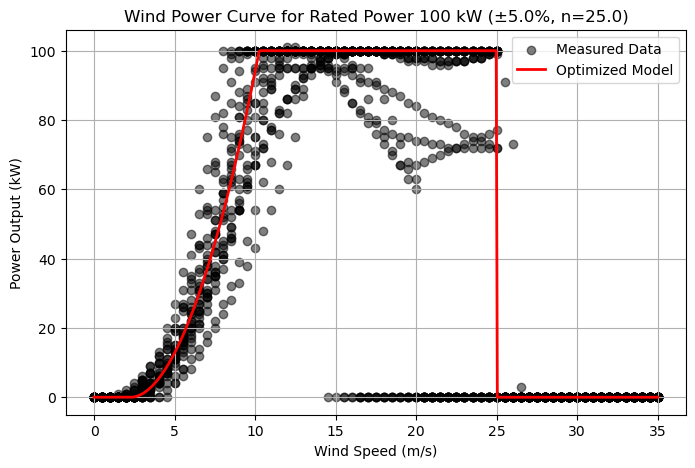

Optimized parameters for Rated Power Output 500
Cut-in Wind Speed: 2.9897683143305667
Rated Wind Speed: 11.305425850973634
Cut-out Wind Speed: 25.0
Exponent (p): 1.6534744279574503



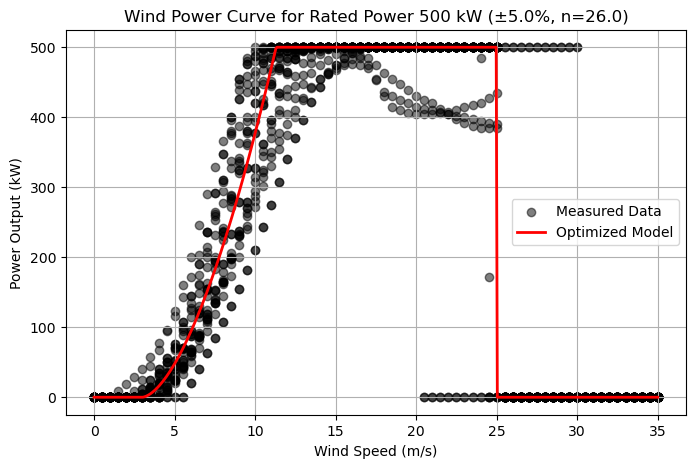

Optimized parameters for Rated Power Output 1000
Cut-in Wind Speed: 2.743544109589729
Rated Wind Speed: 11.609661389774294
Cut-out Wind Speed: 25.0
Exponent (p): 1.8201157967031933



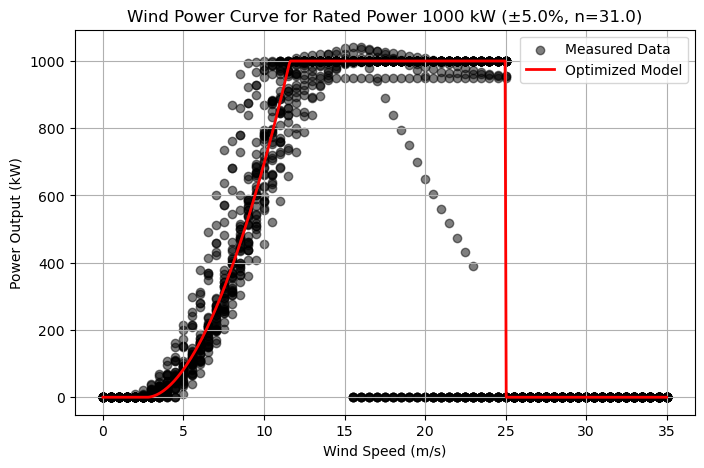

Optimized parameters for Rated Power Output 1500
Cut-in Wind Speed: 2.399598723705244
Rated Wind Speed: 10.923246353854696
Cut-out Wind Speed: 25.0
Exponent (p): 1.9976652394207446



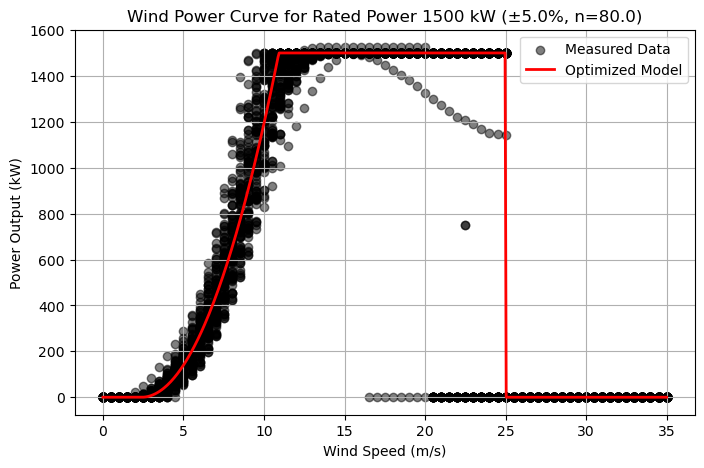

Optimized parameters for Rated Power Output 2000
Cut-in Wind Speed: 2.4481874229833065
Rated Wind Speed: 10.657625064467528
Cut-out Wind Speed: 25.0
Exponent (p): 1.9739289920597436



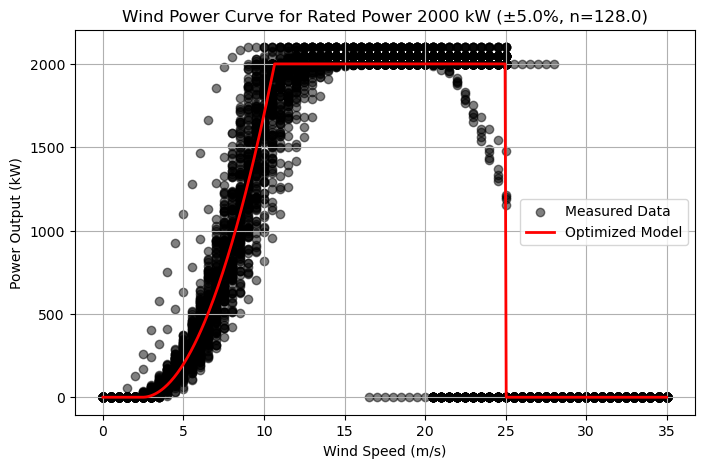

Optimized parameters for Rated Power Output 2500
Cut-in Wind Speed: 2.458014827450874
Rated Wind Speed: 10.756021933698394
Cut-out Wind Speed: 25.0
Exponent (p): 1.9605778807924812



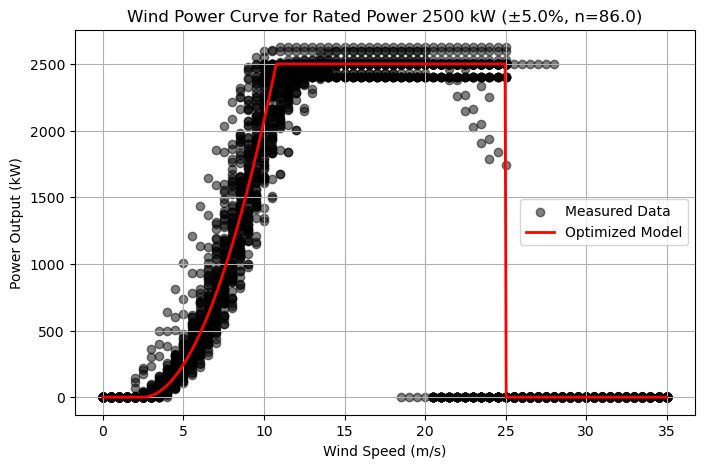

Optimized parameters for Rated Power Output 3000
Cut-in Wind Speed: 2.352990387656381
Rated Wind Speed: 10.878593392714153
Cut-out Wind Speed: 25.0
Exponent (p): 1.9422007723042394



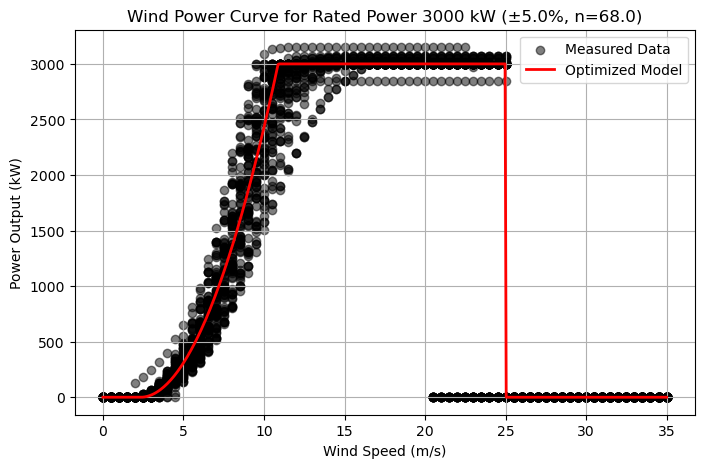

Optimized parameters for Rated Power Output 4000
Cut-in Wind Speed: 2.4043764115658695
Rated Wind Speed: 10.774636392312432
Cut-out Wind Speed: 25.0
Exponent (p): 1.8148715255850232



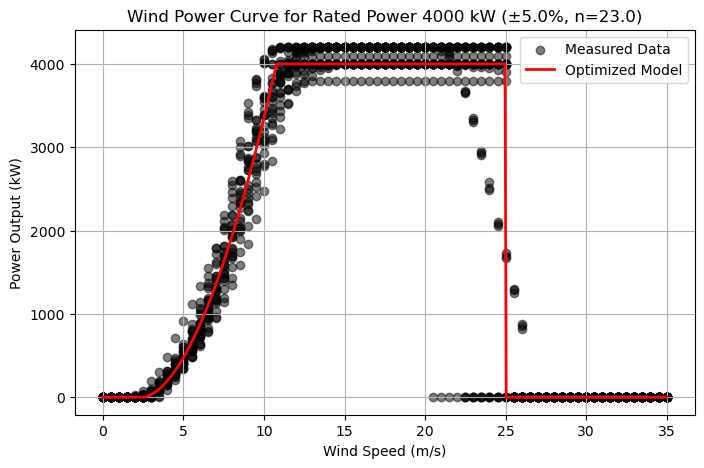

Optimized parameters for Rated Power Output 5000
Cut-in Wind Speed: 2.649376897900453
Rated Wind Speed: 11.824560713028678
Cut-out Wind Speed: 25.0
Exponent (p): 1.896450398407527



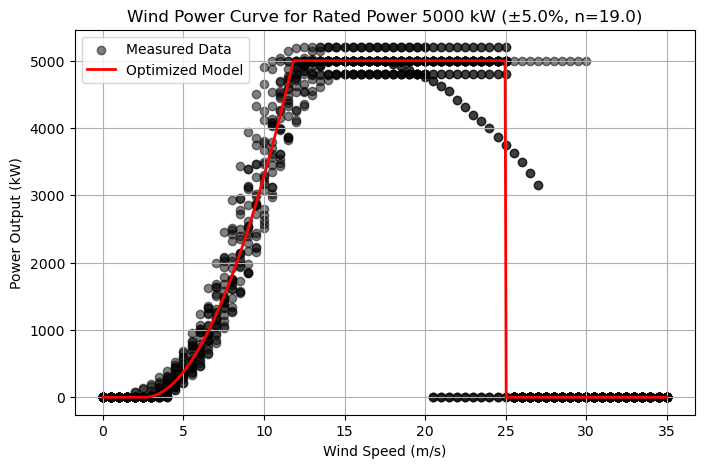

Optimized parameters for Rated Power Output 6000
Cut-in Wind Speed: 2.7318454333660247
Rated Wind Speed: 10.791983025589925
Cut-out Wind Speed: 25.0
Exponent (p): 1.991087849184885



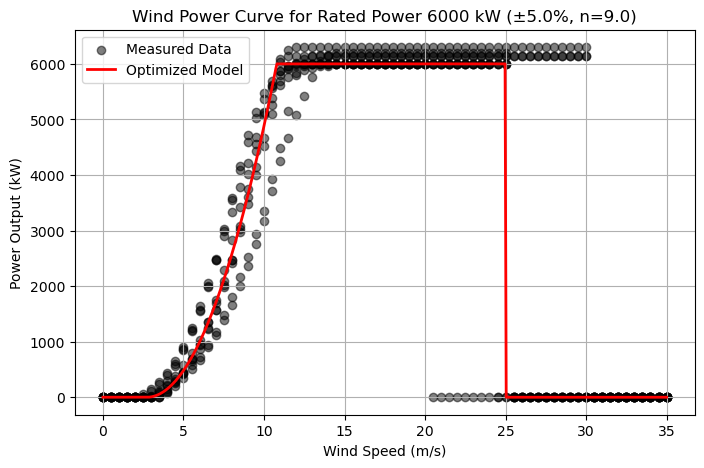

Optimized parameters for Rated Power Output 8000
Cut-in Wind Speed: 3.106214194740412
Rated Wind Speed: 11.754629804718032
Cut-out Wind Speed: 25.0
Exponent (p): 1.7150408533040573



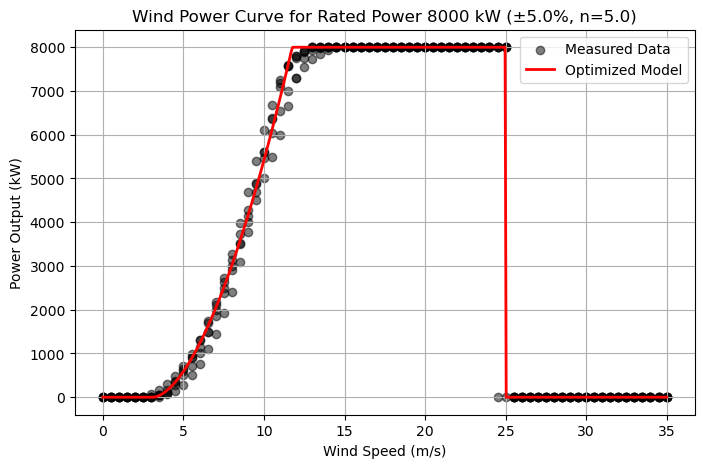

Optimized parameters for Rated Power Output 9000
Cut-in Wind Speed: 2.406157130387065
Rated Wind Speed: 10.540887884572015
Cut-out Wind Speed: 25.0
Exponent (p): 1.7473902859738903



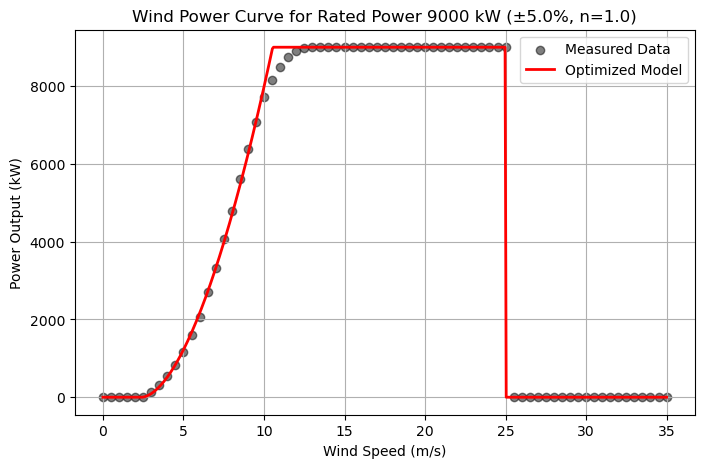

Optimized parameters for Rated Power Output 10000
Cut-in Wind Speed: 2.630019118788031
Rated Wind Speed: 10.894488865390937
Cut-out Wind Speed: 25.0
Exponent (p): 1.9736708863164139



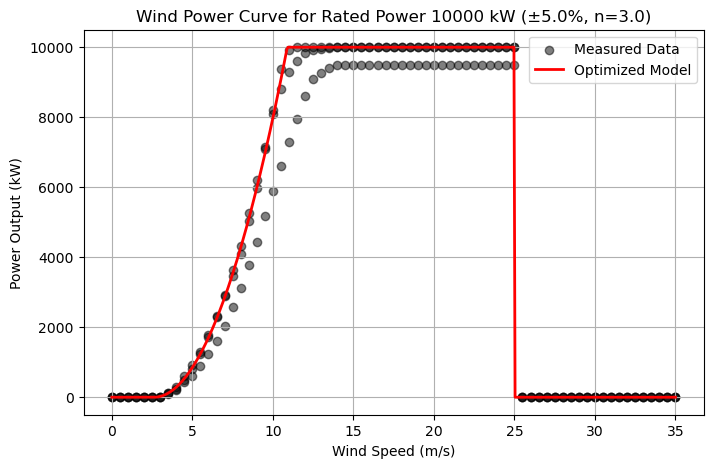

In [15]:

# ---------------------------
# 5. Generate plots for each rated power output
# ---------------------------
for P_rated in rated_power_values_to_plot:
    if P_rated not in optimized_params_intervals:
        continue

    v_ci_opt, v_r_opt, v_co_opt, p_opt = optimized_params_intervals[P_rated]

    print("Optimized parameters for Rated Power Output", P_rated)
    print("Cut-in Wind Speed:", v_ci_opt)
    print("Rated Wind Speed:", v_r_opt)
    print("Cut-out Wind Speed:", v_co_opt)
    print("Exponent (p):", p_opt)
    print()

    # Select data within ±15% interval
    lower_bound = P_rated * (1 - interval)
    upper_bound = P_rated * (1 + interval)
    subset = data[(data["Rated Power Output"] >= lower_bound) & (data["Rated Power Output"] <= upper_bound)]
    wind_speeds_actual = subset["Wind Speed"].values
    measured_power = subset["Power Output"].values

    # Generate predicted power curve
    wind_speeds_range = np.linspace(0, 35, 500)
    predicted_power = turbine_power_curve(wind_speeds_range, P_rated, v_ci_opt, v_r_opt, v_co_opt, p_opt)

    # Plot actual data and model
    plt.figure(figsize=(8, 5))
    plt.scatter(wind_speeds_actual, measured_power, color="black", label="Measured Data", alpha=0.5)
    plt.plot(wind_speeds_range, predicted_power, color="red", linewidth=2, label="Optimized Model")

    plt.xlabel("Wind Speed (m/s)")
    plt.ylabel("Power Output (kW)")
    plt.title(f"Wind Power Curve for Rated Power {P_rated} kW (±{interval * 100}%, n={len(subset)/71})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [1]:
from windisch import *
from windisch.power_curve import calculate_generic_power_curve
import xarray as xr

#update_input_parameters()
tip = TurbinesInputParameters()
tip.static()
#tip.stochastic(3)
_, array = fill_xarray_from_input_parameters(
    tip,
    #scope={"year": [2020, ], "size": [1000,]}
)
fp = "era5_mean_2013-2022_month_by_hour_corrected.nc"
wt = WindTurbineModel(
    array,
    location=(55.602164360115104, 12.491974627997108),
    wind_data=xr.open_dataset(fp),
    #country="DK"
)
# wt.set_all()

a = calculate_generic_power_curve(power=wt["power"])

Fetching terrain data only.
Using cached data for location (55.602164360115104, 12.491974627997108)
Onshore wind turbines


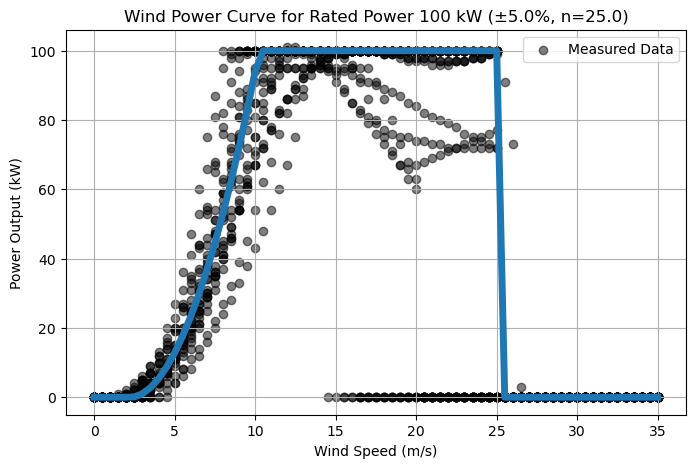

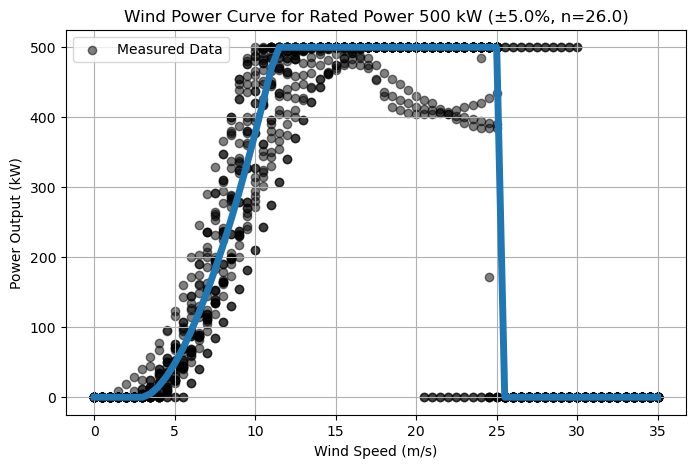

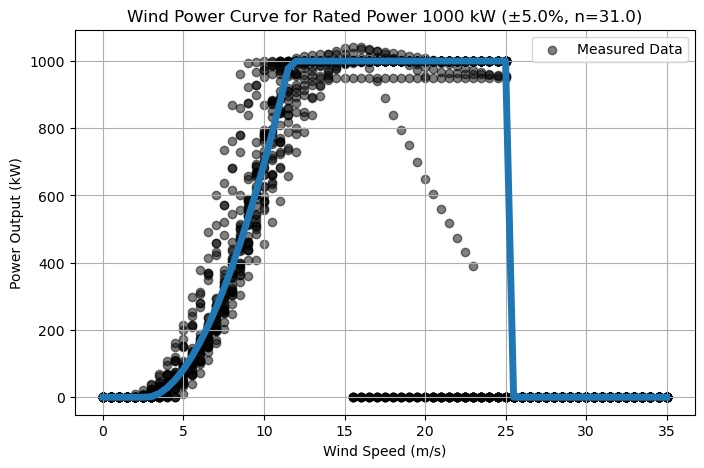

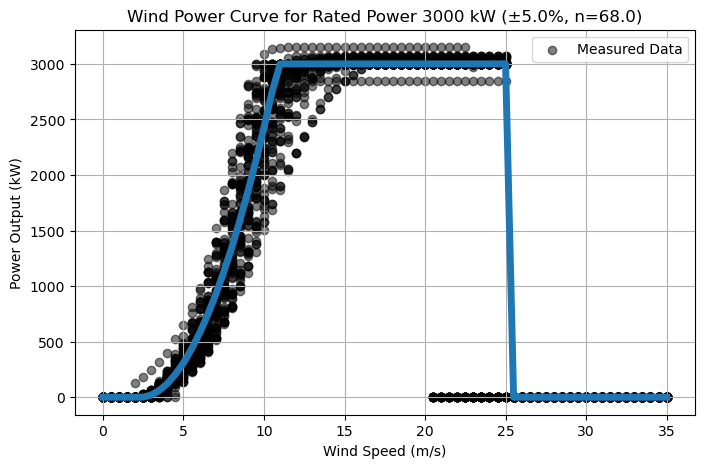

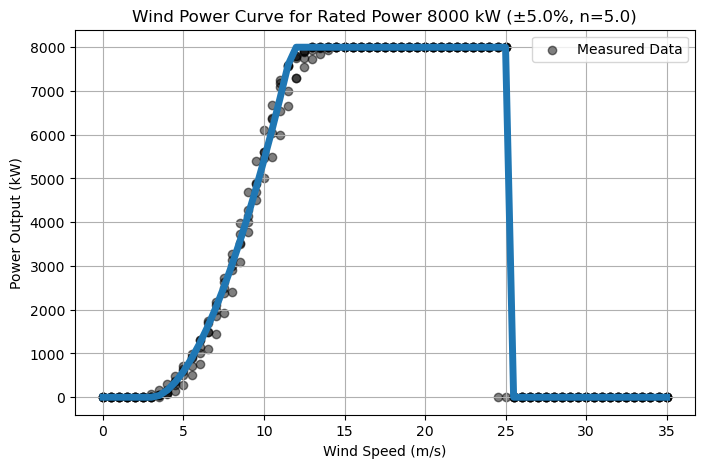

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided CSV file
data = pd.read_csv("reformatted_power_curves.csv")

# Ensure numeric values
data = data.dropna(subset=["Wind Speed", "Power Output"])
data["Rated Power Output"] = pd.to_numeric(data["Rated Power Output"], errors="coerce")
data["Wind Speed"] = pd.to_numeric(data["Wind Speed"], errors="coerce")
data["Power Output"] = pd.to_numeric(data["Power Output"], errors="coerce")

interval = 0.05 # 5%

for P_rated in a.coords["size"]:

    # Select data within interval
    lower_bound = P_rated.values * (1 - interval)
    upper_bound = P_rated.values * (1 + interval)
    subset = data[(data["Rated Power Output"] >= lower_bound) & (data["Rated Power Output"] <= upper_bound)]
    wind_speeds_actual = subset["Wind Speed"].values
    measured_power = subset["Power Output"].values

    # Plot actual data and model
    plt.figure(figsize=(8, 5))
    plt.scatter(wind_speeds_actual, measured_power, color="black", label="Measured Data", alpha=0.5)
    a.sel(size=P_rated, application="onshore", year=2020,).plot(linewidth=5)

    plt.xlabel("Wind Speed (m/s)")
    plt.ylabel("Power Output (kW)")
    plt.title(f"Wind Power Curve for Rated Power {P_rated.values} kW (±{interval * 100}%, n={len(subset)/71})")
    plt.legend()
    plt.grid(True)
    plt.show()